<a href="https://colab.research.google.com/github/abtheo/BrainReadWrite/blob/master/Brain_Computer_Interfaces_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Computer Interfaces

In this notebook, we will analyse the [BCI Competition IV dataset IIa](http://www.bbci.de/competition/iv/#dataset2a) from the Graz University made available by Brunner, Leeb, Müller-Putz, Schlögl, and Pfurtscheller. This dataset contains EEG data recorded while nine participants operated a SMR based BCI using left-hand, right-hand, feet, and tongue movement imagery.


### Learning goals
After this assignment, you will
* have experience with the BCI cycle as applied to a SMR-based BCI
* have experience with applying a band-pass filter
* have experience with spatial filtering using the Laplacian and CSP

### Table of contents

1. [The dataset](#dataset)
    1. [The stimulus paradigm](#stimulus)
    2. [The EEG data](#eeg)
2. [Decoding the neural code](#neural)
    1. [Bandpower features](#bandpower)
    2. [Visualizing features](#features)
    3. [Decoding](#decoding)
4. [Extension: Laplacian spatial filter](#extension1)
    1. [The Laplacian](#laplacian)
    2. [Bandpower features](#bandpower2)
    3. [Visualizing features](#features2)
    4. [Decoding](#decoding2)
5. [Extension: Common spatial patterns](#extension2)
    1. [The CSP](#csp)
    2. [Bandpower features](#bandpower3)
    3. [Visualizing features](#features3)
    4. [Decoding](#decoding3)
    5. [Inspecting classifier](#classifier)
    

In [4]:
# Some imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse, Polygon
from scipy.interpolate import griddata
from scipy.signal import periodogram, butter, filtfilt
from scipy.linalg import eig, inv
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix


In [5]:
def topoplot(z, c, cbar=False):
    """
    Function to plot a topoplot given the values at each electrode `z` and the electrode position file `c` that 
    denotes the electrode positions in polar coordinates.
    
    Args:
        z (numpy.ndarray): array of electrode values
        c (str): txt file containing electrode position information
        cbar (bool): whether or not to add a colorbar (default: False)
    """
    
    # Read electrode positions
    with open(c) as fid:
        lines = fid.read().split("\n")
        xy = np.zeros((len(lines), 2))
        for i, line in enumerate(lines):
            __, t, r, __ = line.split("\t")
            t = (float(t) + 90) / 180 * np.pi
            r = float(r) * 2
            xy[i, :] = r*np.cos(t), r*np.sin(t)
            
    # Add additional points for interpolation to edge of head
    xy = np.concatenate((xy, np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])), axis=0)
    z = np.concatenate((z, np.zeros((4,))), axis=None)

    # Make grid
    N = 300
    xi = np.linspace(-2, 2, N)
    yi = np.linspace(-2, 2, N)
    zi = griddata((xy[:, 0], xy[:, 1]), z, (xi[None,:], yi[:,None]), method="cubic", fill_value="nan")

    # Set points outside radius to nan so they will not be plotted (outside head).
    d = xi[1] - xi[0]
    for i in range(N):
        for j in range(N):
            if np.sqrt(xi[i]**2 + yi[j]**2) + d > 1:
                zi[j, i] = "nan"

    # Make figure
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect=1)
    
    # Add head
    circle = Circle(xy=[0,0], radius=1, edgecolor="k", facecolor="w", zorder=1)
    ax.add_patch(circle)

    # Add ears
    circle = Ellipse(xy=[-1,0], width=0.25, height=0.5, angle=0, edgecolor="k", facecolor="w", zorder=0)
    ax.add_patch(circle)
    circle = Ellipse(xy=[1,0], width=0.25, height=0.5, angle=0, edgecolor="k", facecolor="w", zorder=0)
    ax.add_patch(circle)

    # Add a nose
    polygon = Polygon(xy=[[-0.1,0.9], [0,1.25],[0.1,0.9]], edgecolor="k", facecolor="w", zorder=0)
    ax.add_patch(polygon) 

    # Add the interpolated data
    cs = ax.contourf(xi, yi, zi, 60, cmap=plt.cm.jet, zorder=2)
    ax.contour(xi, yi, zi, 15, colors="grey", zorder=3)

    # Add data points
    ax.scatter(xy[:-4,0], xy[:-4,1], marker="o", c="k", s=15, zorder=4)
    
    # Add color bar
    if cbar:
        fig.colorbar(cs, ax=ax)

    # Make the axis invisible 
    plt.axis("off")

    # set axes limits
    ax.set_xlim(1.25, -1.25)
    ax.set_ylim(-1.25, 1.25)
    

In [6]:
def confusionmatrix(T, Y):
    """
    Function to plot a confusion matrix.
    
    Args:
        T (ndarray): target labels
        Y (ndarray): predicted labels
    """

    # Confusion matrix
    cm = confusion_matrix(T.flatten(), Y.flatten())

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           ylabel="True label",
           xlabel="Predicted label")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, "{}".format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    

# 1. The dataset<a class="anchor" id="dataset"></a>
Download the data to a specific location on your computer, and change the variable `path_to_data` accordingly. 

In [7]:
"""Setting Root Directory:
Change root_dir to your relative path to the tutorial folder."""
!git clone "https://github.com/abtheo/BrainReadWrite/" ./temp    # clone github repository to temp folder
!mkdir /content/data
!mv ./temp/data/* /content/data      # move all files/folders in temp folder to folder defined in project path
!rm -rf ./temp                      # remove all the files/folders in temp folder

path_to_data = "/content/data/assignment2_data.npz"

Cloning into './temp'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 27 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (27/27), done.
mkdir: cannot create directory ‘/content/data’: File exists


To load the data, execute the cell below. It loads into memory a training set and a validation set of one participant. We will use the training set to inspect the data and calibrate a classifier, and the validation set to evaluate the performance of the classifier. In fact, in the original competition, one was not given the target values of the validation set, which had to be predicted and submitted and were evaluated to get a position on the [leaderboard](http://www.bbci.de/competition/iv/results/index.html). 

Some words on the dataset:
* $X \in \mathbb{R}^{k, m, c}$ are the EEG data of $k$ single-trials, $m$ samples, and $c$ channels. With single-trials we mean the participant is foxussing on one symbol. With samples we mean time-points (to convert samples to time, use the samplefrequency, i.e., the number of samples per second (Hz)). With channels we mean the voltage difference between a recording and reference electrode.
* $T \in \mathbb{R}^{k}$ are the target labels of $k$ single-trials. This representes the ground truth, i.e., left or right hand movement imagery.

In [8]:
# Load the data
tmp = np.load(path_to_data)
X_train = tmp["X_train"]
T_train = tmp["T_train"]
X_valid = tmp["X_valid"]
T_valid = tmp["T_valid"]
channels = tmp["channels"].tolist()
fs = tmp["fs"]

# Print some properties
print("Data has timeseries of {} channels at {} Hz".format(len(channels), fs))
print("Channels:", channels)
print("Training data:")
print("\tX: ", X_train.shape, X_train.dtype)
print("\tT: ", T_train.shape, T_train.dtype)
print("Validation data:")
print("\tX: ", X_valid.shape, X_valid.dtype)
print("\tT: ", T_valid.shape, T_valid.dtype)


Data has timeseries of 22 channels at 250 Hz
Channels: ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']
Training data:
	X:  (144, 750, 22) float32
	T:  (144,) uint8
Validation data:
	X:  (144, 750, 22) float32
	T:  (144,) uint8


### 1.1. The stimulus paradigm (0.25 points) <a class="anchor" id="stimulus"></a>
During the experiment, the participant imagined left-hand versus right-hand movement (originally also feet and tongue). Let's inspect whether we have a balanced dataset. Plot a histogram of the target labels in `T_train` using `plt.hist()`. 

Do we have a balanced dataset?

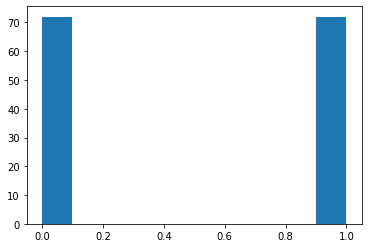

#Zeros = 72 
#Ones = 72


In [9]:
plt.hist(T_train)
plt.show()

"""Yup, looks pretty balanced to me!"""
print(f"#Zeros = {(T_train==0).sum()} \n#Ones = {(T_train==1).sum()}")

### 1.2. The EEG data (0.25 points) <a class="anchor" id="eeg"></a>
Let's inspect the EEG data itself. The variable `X_train` contains the EEG data, we have a list of the channel names `channels` so we know which channel was located where on the scalp, and we have the sample frequency `fs`, i.e., the number of measurements per second. 

Now, plot a trial (e.g., the first) of channel C3 and one of C4. Use `plt.plot()` to overlay them in the same figure. Add sensible labels on the axes, and make sure the x axis representes time, note samples (think about the difference). Note, to find the index of a channel, you can use `channels.index("C3")`.

Can you interpret the data visually, i.e., can you derive which hand movement (left versus right) the participant imagined? 


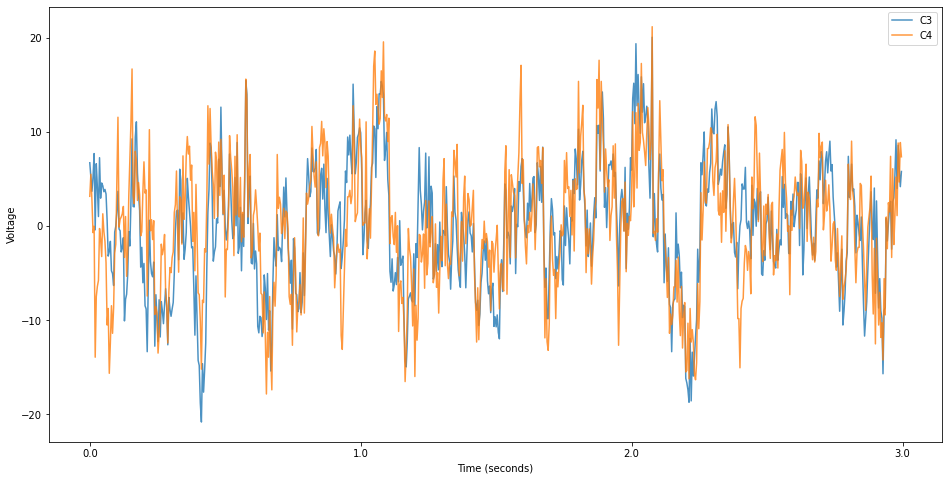

In [10]:
#Increase plot size, lots of data to fit
plt.figure(figsize=(16,8))

plt.plot(X_train[0, :, channels.index("C3")], label="C3", alpha=.8)
plt.plot(X_train[0, :, channels.index("C4")], label="C4", alpha=.8)

#Convert iterations to second time ticks using frequency
ticks = np.arange(0, X_train.shape[1]+1, step=fs)
plt.xticks(ticks=ticks,labels=ticks/fs)

#Fancification
plt.xlabel("Time (seconds)")
plt.ylabel("Voltage")
plt.legend()
plt.show()

The above visualization shows us the data in the temporal domain. Let's transform this data to the frequency-domain and inspect which frequencies are present in the data. Especially for SMR based BCI this is important.

Compute the frequency spectrum (i.e., power spectral density) of `X_train` using `periodogram()` from SciPy. Make sure the power spectrum is computed over the correct axis and with the correct samplefrequency. Then, plot the frequency spectrum of the same trial as above (e.g., the first) for channels C3 and C4. Again, add sensible labels to the axes.

What do you observe? What can you say about the peaks in the lower spectrum, and what can you say about the peak at 50 Hz? Also, why do we see frequencies only up to 120 Hz when in fact our samplefrequency is higher?

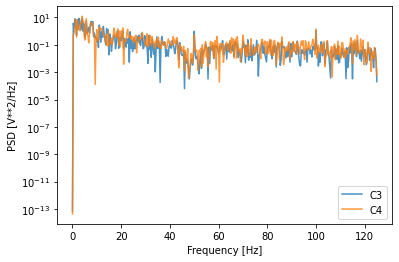

In [11]:
#First trial, all samples, from each channel
f_c3, Pxx_den_c3 = periodogram(X_train[0,:,channels.index("C3")],fs=fs)
f_c4, Pxx_den_c4 = periodogram(X_train[0,:,channels.index("C4")],fs=fs)

plt.semilogy(f_c3, Pxx_den_c3, label="C3",alpha=.8)
plt.semilogy(f_c4, Pxx_den_c4, label="C4",alpha=.8)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()


# 2. Decoding the neural code<a class="anchor" id="neural"></a>
In this assignment we work with SMRs. We know that these particularly occur at the mu (8-12 Hz) and beta (12-30 Hz) bands. In a SMR-based BCI, one way to go is to use the average power envelope of these bands as features. 

### 2.1. Bandpower features (2.0 point)<a class="anchor" id="bandpower"></a>
Implement the function `bandpower(X)`, which computes band-power features for a particular dataset.

First, apply two band-pass filters: one with a cut-off frequency of 8 to 12 Hz (mu band) and another with 12-30 Hz (beta band). To design these filters, use `butter()` from SciPy, and to apply the filter use `filtfilt` from SciPy. Note, there is plenty of choice in filter types and filter parameters to choose from. Here, use filters of order 5. Note, this step is not neccessarily a preprocessing step, but can be considered to be a feature selection step too. Obviously, these steps tend to be intertwined a lot. Make sure that the filter functions are using the right sample frequency and are applied to the right axis. If you do not know how to do so, lookup the documentation of the function on google.

Second, rectify the band-passed data by squaring it. This makes sure that the oscillations, that now oscilate around 0, will be positive always, which is needed for the next step.

Finally, take the average over time to get band-power features for individual trials. 

Apply the bandpower function to both `X_train` as well as `X_valid`. This pipeline should create the variables `F_train` and `F_valid` that are of shape $F \in \mathbb{R}^{k,f,c}$, with $k$ the number of trials, $f$ the number of power-bands (mu and beta), and $c$ the number of channels (C3 and C4).

What do the band-pass filters do? If you cannot answer these questions directly, look at what the data looks like before and after filtering.


In [12]:
def bandpower(X,plot=False):
  #Mu Band Filter
  low_b, low_a = butter(5, [8,12], btype="bandpass", fs=fs)
  mu_signal = filtfilt(low_b, low_a, X, axis=1)

  #Beta Band Filter
  high_b, high_a = butter(5, [12,30], btype="bandpass", fs=fs)
  beta_signal = filtfilt(high_b, high_a, X, axis=1)


  if plot:
    #Take a look at the bands!
    plt.figure(figsize=(16,8))
    #Plot the different frequency bands seperately for the same trial
    plt.plot(mu_signal[0, :, channels.index("C3")], label="Mu C3", alpha=.8)
    plt.plot(beta_signal[0, :, channels.index("C3")], label="Beta C3", alpha=.8)

    #Convert iterations to second time ticks using frequency
    ticks = np.arange(0, X_train.shape[1]+1, step=fs)
    plt.xticks(ticks=ticks,labels=ticks/fs)

    #Fancification
    plt.xlabel("Time (seconds)")
    plt.ylabel("Voltage")
    plt.legend()
    plt.show()

  """
  Bandpass filtering selects only frequencies within a given range.
  Here, we use the filter to pick out: 
  * Mu waves - suppressed when performing / thinking about motor action
  * Beta waves - are suppressed prior to and during movement changes
  """

  #Back to work - square the signals
  mu_squared = mu_signal ** 2
  beta_squared = beta_signal ** 2

  #Average over time axis (trials,time,channels) -> (trials,1,channels)
  mu = np.mean(mu_squared,axis=1,keepdims=True)
  beta = np.mean(beta_squared,axis=1,keepdims=True)

  #Zip into desired shape (trials,2,channels)
  return np.hstack((mu,beta))

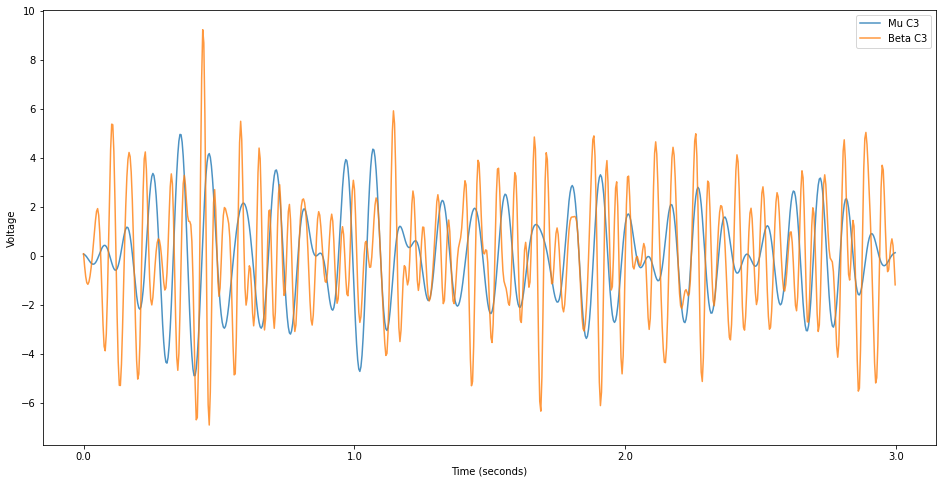

F_train: (144, 2, 22) float64
F_valid: (144, 2, 22) float64


In [13]:
F_train = bandpower(X_train, plot=True)
F_valid = bandpower(X_valid)
# Print the shapes of F
print("F_train:", F_train.shape, F_train.dtype)
print("F_valid:", F_valid.shape, F_valid.dtype)

### 2.2. Visualizing features (0.5 points)<a class="anchor" id="features"></a>
A first thing to check is that we processed the data correctly and that we actually recorded good SMRs. We can do so by computing averages over trials in the training data for individual classes: left-hand versus right-hand movement imagery.

Compute the mean features over all trials for left and for right hand movement imagery. Then, plot the averages as bar plots with `plt.bar()` showing the average C3 and C4 amplitude for both left as well as right hand movement imagery for both mu and beta. Make sure that you can easily compare left versus right hand movement, by putting these bars next to each other. Add sensible labels to the axes, add a legend if needed.

What can you observe from the visualization? Do you see clear lateralisation effects?

Note, we have plotted the averages only. Good practice would be to also plot the variance.

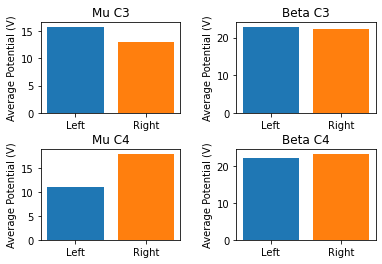

In [14]:
#Split left/right
left_F_train = F_train[T_train==0]
right_F_train = F_train[T_train==1]

#Mean features over trials
left_F_averages = np.mean(left_F_train,axis=0)
right_F_averages = np.mean(right_F_train,axis=0)

#Plot all the graphs!
plt.subplot(2,2,1)
plt.bar(0,left_F_averages[0,channels.index("C3")])
plt.bar(1,right_F_averages[0,channels.index("C3")])
plt.title("Mu C3")
plt.ylabel("Average Potential (V)")
plt.xticks(ticks=[0,1],labels=["Left", "Right"])

plt.subplot(2,2,2)
plt.bar(0,left_F_averages[1,channels.index("C3")])
plt.bar(1,right_F_averages[1,channels.index("C3")])
plt.title("Beta C3")
plt.ylabel("Average Potential (V)")
plt.xticks(ticks=[0,1],labels=["Left", "Right"])

plt.subplot(2,2,3)
plt.bar(0,left_F_averages[0,channels.index("C4")])
plt.bar(1,right_F_averages[0,channels.index("C4")])
plt.title("Mu C4")
plt.ylabel("Average Potential (V)")
plt.xticks(ticks=[0,1],labels=["Left", "Right"])

plt.subplot(2,2,4)
plt.bar(0,left_F_averages[1,channels.index("C4")])
plt.bar(1,right_F_averages[1,channels.index("C4")])
plt.title("Beta C4")
plt.ylabel("Average Potential (V)")
plt.xticks(ticks=[0,1],labels=["Left", "Right"])

#Fancification
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


### 2.3. Decoding (1 point) <a class="anchor" id="decoding"></a>
Despite the clear effect in the features as observed from the averages, we need to be able to classify individual trials. For this, we first need to vectorize the features so that the data is a 2D matrix of shape examples times features. Here, we use the mu and beta bandpower at C3 and C4 as features, so we have 4 features in total per trial. 

Make a pipeline using `make_pipeline()` from sklearn that first normalises the data using `StandardScaler()` and then applies LDA using `LinearDiscriminantAnalysis()` from sklearn. Make sure that the LDA uses eigen as solver and auto shrinkage. Calibrate the classifier on the training features.

Then, apply the classifier to both training as well as validation data with the `predict()` method to obtain label predictions. With these, compute the accompanying classifcation accuracies and plot confusion matrices.

Did the classifier do well?

In [15]:
def calibrate(X, T):
  #Perform bandpass filtering
  features = bandpower(X)#(144,2,22)

  #Extract channels
  f_chan = features[:, :, [channels.index("C3"), channels.index("C4")]]#144,2,2
  #then vectorize to (144,4)
  X_features = np.reshape(f_chan, (X.shape[0], f_chan.shape[1] * f_chan.shape[2])) 

  #Construct and fit pipeline
  pipeline = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto'))

  pipeline.fit(X_features, T)

  return X_features, pipeline

Train Set Results:
Accuracy: 0.7916666666666666


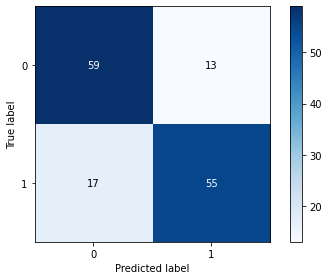

In [16]:
#Fit a classifier pipeline on the training data
X_features, clf = calibrate(X_train,T_train)

#Make predictions
train_predictions = clf.predict(X_features)

#Evaluate results
print("Train Set Results:")
confusionmatrix(T_valid, train_predictions)
print(f"Accuracy: {np.mean(train_predictions==T_valid)}")


Test Set Results:
Accuracy: 0.7777777777777778


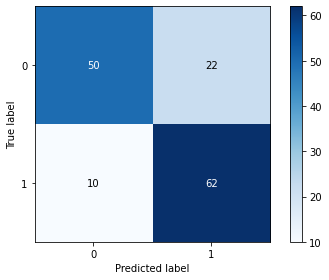

In [17]:
#Use calibrate function to extract features, 
#but discard the fitted classifier,
#and use the one fit on training data.
X_valid_features, _ = calibrate(X_valid,T_train)

test_predictions = clf.predict(X_valid_features)
print("Test Set Results:")
confusionmatrix(T_valid, test_predictions)
print(f"Accuracy: {np.mean(test_predictions==T_valid)}")

# 3. Extension: Laplacian spatial filter<a class="anchor" id="extension1"></a>
Instead of preselecting certain channels, we can utilize the fact that multiple electrodes were used to record the EEG. These electrodes can be used to add information about the signal that we are interested in, but can also help in removing noise sources. The first spatial filter that we will employ is the Laplacian.

### 3.1. The Laplacian (1 point) <a class="anchor" id="laplacian"></a>
The Laplacian in general takes the first derivative, in this case a spatial derivative. A simple way of implementing this is to make center-surround configurations. Specifically:
$$y(t)_i = n*y(t)_i - \sum^n_j y(t)_j$$
where $i$ is the to be filtered electrode, and $j$ are the neighbours of $i$. 

Let's focus again on C3 and C4, this means:
$$y(t)_{C3} = 4*y(t)_{C3} - y(t)_{FC3} - y(t)_{C5} - y(t)_{C1} - y(t)_{CP3}$$
$$y(t)_{C4} = 4*y(t)_{C4} - y(t)_{FC4} - y(t)_{C2} - y(t)_{C6} - y(t)_{CP4}$$
Implement a function `laplacian(X, ch)` that computes the laplacian for channel `ch` that is either C3 or C4.

Apply the function to both training and validation data, storing them in `F_train` and `F_valid`.


In [18]:
#Channels: ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']

def laplacian(X, ch):
  #I don't trust the channel indexes to be ordered as specified above.
  #So no looping, manual conditionals it is...
  if ch == "C3":
    #Apply filter to channel
    C3_laplacian = 4 * X[:, :, channels.index("C3")] - X[:, :, channels.index("FC3")] - X[:, :, channels.index("C5")] - X[:, :, channels.index("C1")] - X[:, :, channels.index("CP3")]
    #Overwrite channel with filter
    X[:,:,channels.index("C3")] = C3_laplacian
  if ch == "C4":
    X[:,:,channels.index("C4")] = 4 * X[:, :, channels.index("C4")] - X[:, :, channels.index("FC4")] - X[:, :, channels.index("C2")] - X[:, :, channels.index("C6")] - X[:, :, channels.index("CP4")]

  return X

In [19]:
#Apply twice, to filter both channels.
laplacian_train = laplacian(X_train,"C3")
laplacian_train = laplacian(laplacian_train,"C4")

laplacian_valid = laplacian(X_valid,"C3")
laplacian_valid = laplacian(laplacian_valid,"C4")

### 3.2. Bandpower features (0.5 points) <a class="anchor" id="bandpower2"></a>
Now, compute the bandpower features with the `bandpower` function, but this time for the spatially filtered C3 and C4 channels. 

In [20]:
F_train = bandpower(laplacian_train)
F_valid = bandpower(laplacian_valid)

# Print the shapes of F
print("F_train:", F_train.shape, F_train.dtype)
print("F_valid:", F_valid.shape, F_valid.dtype)


F_train: (144, 2, 22) float64
F_valid: (144, 2, 22) float64


### 3.3. Visualizing features (0.5 points) <a class="anchor" id="features2"></a>
Like before, visualize the bandpower features per channel in a bar plot. You can reuse (parts of) your code from above. 

Did the features benefit from the Laplacian?

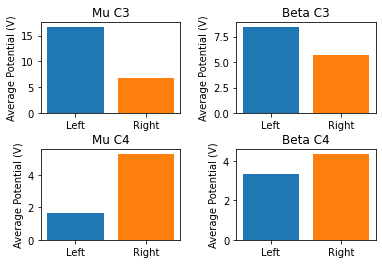

In [21]:
#Split left/right
left_F_train = F_train[T_train==0]
right_F_train = F_train[T_train==1]

#Mean features over trials
left_F_averages = np.mean(left_F_train,axis=0)
right_F_averages = np.mean(right_F_train,axis=0)

#Plot all the graphs!
plt.subplot(2,2,1)
plt.bar(0,left_F_averages[0,channels.index("C3")])
plt.bar(1,right_F_averages[0,channels.index("C3")])
plt.title("Mu C3")
plt.ylabel("Average Potential (V)")
plt.xticks(ticks=[0,1],labels=["Left", "Right"])

plt.subplot(2,2,2)
plt.bar(0,left_F_averages[1,channels.index("C3")])
plt.bar(1,right_F_averages[1,channels.index("C3")])
plt.title("Beta C3")
plt.ylabel("Average Potential (V)")
plt.xticks(ticks=[0,1],labels=["Left", "Right"])

plt.subplot(2,2,3)
plt.bar(0,left_F_averages[0,channels.index("C4")])
plt.bar(1,right_F_averages[0,channels.index("C4")])
plt.title("Mu C4")
plt.ylabel("Average Potential (V)")
plt.xticks(ticks=[0,1],labels=["Left", "Right"])

plt.subplot(2,2,4)
plt.bar(0,left_F_averages[1,channels.index("C4")])
plt.bar(1,right_F_averages[1,channels.index("C4")])
plt.title("Beta C4")
plt.ylabel("Average Potential (V)")
plt.xticks(ticks=[0,1],labels=["Left", "Right"])

#Fancification
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


### 3.4. Decoding (0.5 points)<a class="anchor" id="decoding2"></a>
Like before, vectorize the features, setup a decoding pipeline, calibrate the classifier, predict the labels, compute classification accuracies and plot cunfusion matrices. You can reuse (parts of) your code from above. 

Did the decoding benefit from the Laplacian?

Train Set Results:
Accuracy: 0.9305555555555556


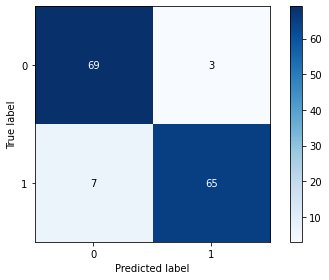

In [22]:
#Fit a classifier pipeline on the training data
X_laplacian_train, clf = calibrate(laplacian_train,T_train)

#Make predictions
laplacian_train_predictions = clf.predict(X_laplacian_train)

#Evaluate results
print("Train Set Results:")
confusionmatrix(T_valid, laplacian_train_predictions)
print(f"Accuracy: {np.mean(laplacian_train_predictions==T_valid)}")


Test Set Results:
Accuracy: 0.8958333333333334


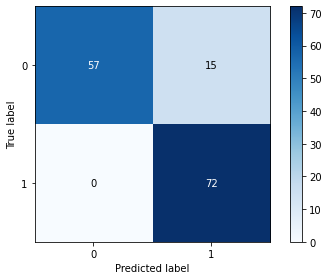

In [23]:
#Use calibrate function to extract features, 
#but discard the fitted classifier,
#and use the one fit on training data.
X_laplacian_valid, _ = calibrate(laplacian_valid,T_train)

laplacian_test_predictions = clf.predict(X_laplacian_valid)
print("Test Set Results:")
confusionmatrix(T_valid, laplacian_test_predictions)
print(f"Accuracy: {np.mean(laplacian_test_predictions==T_valid)}")

Wow, much better results, nice!

# 4. Extension: Common spatial patterns <a class="anchor" id="extension2"></a>
The Laplacian is based on geometric information. Instead, we can also inform the spatial filter about the task. Such type of spatial filter is a supervised one, and an example is common spatial patterns.

### 4.1. The CSP (1.5 points)<a class="anchor" id="csp"></a>
The CSP computes spatial filters by optimizing the following:
$$W = {\arg\max}_W\frac{W^\top X_0}{W^\top X_1}$$
Specifically, it optimizes a spatial filter in such a way that the variance of the one class is maximized while minimizing the variance of the other class. In other words, it separates the two classes by maximizing the difference in their variance. The above formulation is for a two-class problem, but the CSP can be applied to multiclass problems too by optimizing task-specific (one versus rest) $W$'s. 

The above is solved by first computing task-specific covariance matrices $C_0$ and $C_1$ with `np.cov()` on reshaped and permuted data of shape $X \in \mathbb{R}^{c, k*m}$. Specifically, compute a covariance matrix `C0` using the channel-wise covariance of left-hand data, and another `C1` for right-hand data. Then, we perform a generalized eigenvalue decomposition by performing `D, V = eig(C_0, C_1)`. This decomposition makes sure that $V^\top C_0V=D$ and $V^\top C_1=I$. This is equivalent to performing an eigen decomposition with $C_0^\top C_1=V^\top DV$.

Write a function `fit_csp(X, Y)` that performes the above steps. Make sure that the eigenvectors are sorted on decreasing eigenvalues. Return the eigenvectors (i.e., these are the spatial filters). Use the function to fit CSPs using the training data, outputing the spatial filters as `W`.

In [24]:
# code here.

Now, write a function `apply_csp(X, W)` that takes a set of CSP filters `W`, and applies them to the data in `X`. This is an easy mathematical operation, performed by looping over trials or by reshaping the data to a 2D matrix.

Use the function to spatially filter both `X_train` and `X_valid`. Do so making use of 3 CSP pairs (i.e., 6 filters). Specifically, use the first 3 components and last 3 components (i.e., the components are the eigenvectors). Stack these in variables `F_train` and `F_valid`, asif we have 6 channels. 


In [25]:
# code here.

In [26]:
# Print the shapes of F
print("F_train:", F_train.shape, F_train.dtype)
print("F_valid:", F_valid.shape, F_valid.dtype)


F_train: (144, 2, 22) float64
F_valid: (144, 2, 22) float64


### 4.2. Bandpower features (0.5 points)<a class="anchor" id="bandpower3"></a>
Now, compute the bandpower features like before, but this time for the CSP patterns. You can reuse (parts of) your code from above.

In [27]:
# code here.

### 4.3. Visualizing features (0.5 points)<a class="anchor" id="features3"></a>
Like before, visualize the bandpower features per channel in a bar plot. You can reuse (parts of) your code from above. Note, we have more "channels" now.

Did the features benefit from the CSP?

In [28]:
# code here.

### 4.4. Decoding (0.5 points)<a class="anchor" id="decoding3"></a>
Like before, vectorize the features, setup a decoding pipeline, calibrate the classifier, predict the labels, compute classification accuracies and plot cunfusion matrices. You can reuse (parts of) your code from above. 

Did the decoding benefit from the CSP?

In [29]:
# code here.

### 4.5. Inspect classifier (0.5 points)<a class="anchor" id="classifier"></a>
We can inspect the classifier to obtain insight in what the classifier learned. Use the `topoplot()` function with the `assignment2_channels.txt` layout file to plot the first and last CSP in `W`. 

Can you explain what the spatial filters mean? Specifically, why do you observe the clear lateralisation?

In [30]:
# code here.